**Full Name:**

**Student Number:**


# Denoising Autoencoder
In this notebook, you are going to build and train a denoising autoencoder. The purpose of an autoencoder, a form of neural network, is to develop codings for data. 

An autoencoder has two parts: an encoder and a decoder. The encoder modifies the input data and produces a representation for the input in a smaller dimension, and the decoding function reconstructs the input data from the encoded representation. 

A denoising autoencoder is an autoencoder that gets noisy data as input and tries to produce the denoised output for that input.

In [1]:
!pip install torchsummary

In [3]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE 

**For this question, it's highly recommended to use a CUDA-enabled environment.**
We'll check for the availability of GPU and set `device` accordingly.

In [4]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

## Preparing the data
You'll use [Fashion MNIST](https://en.wikipedia.org/wiki/Fashion_MNIST) dataset to train your DAE.

100%|██████████| 26421880/26421880 [00:00<00:00, 113744634.07it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4474945.15it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 66814746.89it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9528807.15it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



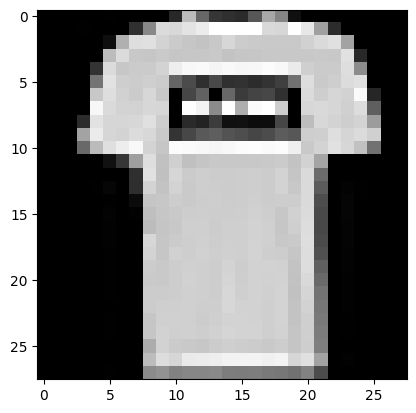

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [5]:
fm_train_set = datasets.FashionMNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
fm_test_set = datasets.FashionMNIST(root='./', train=False, download=True, transform=transforms.ToTensor())

# For both the `fm_train_set` and `fm_test_set` only keep the 
# images and leave out the labels.
# Also, normalize the values to be between [0, 1].
##############################
# Your code goes here (5 points)
# DataLoader will run ToTensor transform which automatically normalizes the data 
train_imgs = torch.stack([img.squeeze(0, 1) for img, _ in DataLoader(fm_train_set)])
test_imgs = torch.stack([img.squeeze(0, 1) for img, _ in DataLoader(fm_test_set)])
##############################

plt.imshow(train_imgs[1].unsqueeze(0).permute(1, 2, 0), cmap='gray')
plt.show()
print(train_imgs.shape, test_imgs.shape)

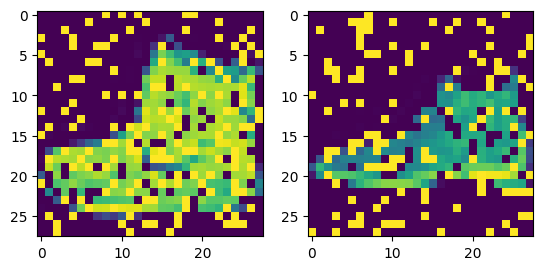

In [6]:
# For each image in our training and test sets,
# create a noisy version of the image.
# We'll use these noisy images as input data for the
# dataset we're going to create. The labels of this dataset
# would be the original images.
##############################
# Your code goes here (10 points)

def add_binomial_noise(imgs, p=torch.tensor([0.15, 0.7, 0.15]) ): 
    flat_noise = torch.multinomial(p, imgs.numel(), replacement=True) - 1
    return torch.clamp(imgs + flat_noise.view_as(imgs), max=1, min=0) 

# adding 30% noise 
noisy_train_imgs = add_binomial_noise(train_imgs) 
noisy_test_imgs = add_binomial_noise(test_imgs) 

##############################
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(noisy_train_imgs[0])
f.add_subplot(1, 2, 2)
plt.imshow(noisy_test_imgs[0])
plt.show()

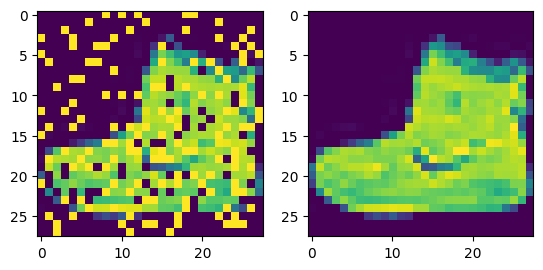

In [7]:
# Now we want to construct our new training and test sets.
# To do so, you'll use the noisy images you've created for each set
# as input for the new dataset and the original Fashion MNIST images as labels.

# Construct `training_set` (data, label) pairs.
##############################
# Your code goes here (10 points)
train_set = torch.cat((noisy_train_imgs.unsqueeze(0), train_imgs.unsqueeze(0)), dim=0)
##############################

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(train_set[0][0]) 
f.add_subplot(1, 2, 2)
plt.imshow(train_set[1][0])
plt.show()

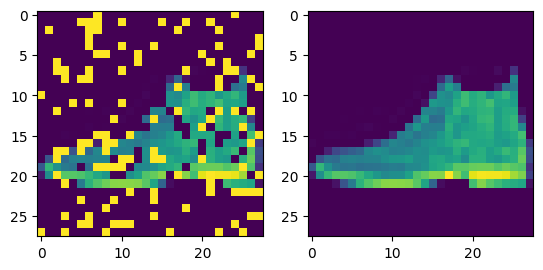

In [8]:
# Construct `test_set` (data, label) pairs.
##############################
# Your code goes here (5 points)
test_set = torch.cat((noisy_test_imgs.unsqueeze(0), test_imgs.unsqueeze(0)), dim=0)
##############################

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(test_set[0][0]) 
f.add_subplot(1, 2, 2)
plt.imshow(test_set[1][0])
plt.show()

In [9]:
# Finally, create DataLoaders for the datasets.
# Use a batch size of 128 and enable shuffling.
##############################
# Your code goes here (5 points)
batch_size=128 
shuffle=True

train_set = train_set.unsqueeze(2)
test_set = test_set.unsqueeze(2)

train_set = TensorDataset(train_set[0,...], train_set[1,...])
test_set = TensorDataset(test_set[0,...], test_set[1,...])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=shuffle)

##############################

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x79d71898b9d0>,
 <torch.utils.data.dataloader.DataLoader at 0x79d7188336d0>)

## Creating the Model


In this part, you're going to create the DAE model.

In [10]:
# The encoder takes the input and outputs the `encoded representation`.
# Create the encoder using nn.Sequential (You can use the architecture 
# shown in this cell's output).
# Use Conv2d layers followed by ReLU.
# After conv2d layers, flatten the data and use linear layers to
# smoothly transform the output from conv2d layers into the encoded space.
# Set the encoded space dimensions to 10 * 1.
##############################
# Your code goes here (15 points)

##############################
encoder = nn.Sequential(
    # Convolutional layers
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),  # Output: (16, 14, 14) for 28x28 input
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),  # Output: (32, 7, 7)
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7),  # Output: (64, 1, 1) for 7x7 input
    nn.ReLU(),
    nn.Flatten(),  # Flatten the output of conv layers
    # Linear layers
    nn.Linear(in_features=64, out_features=120),  # Flatten output is 64, adjust if your conv outputs differ
    nn.ReLU(),
    nn.Linear(in_features=120, out_features=10)  # Output encoded space dimensions: 10
).to(device)

summary(encoder, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
              ReLU-2           [-1, 16, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]           4,640
              ReLU-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 1, 1]         100,416
              ReLU-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                  [-1, 120]           7,800
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 10]           1,210
Total params: 114,226
Trainable params: 114,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.44
Estimated T

In [11]:
# The decoder takes the encoded data generated by the encoder
# and outputs the original input.
# Create the decoder using nn.Sequential.
# Reverse the operations used in encoder.
##############################
# Your code goes here (15 points)

decoder = nn.Sequential(
    # Reverse of the linear layers (start from the encoded dimension)
    nn.Linear(10, 120),
    nn.ReLU(),
    nn.Linear(120, 64),
    nn.ReLU(),
    
    # Prepare for ConvTranspose2d layers by reshaping
    # Assume the output from the last linear layer needs to match the input shape of the first ConvTranspose2d layer
    # This requires knowing the shape before flattening in the encoder; here we assume it was (64, 1, 1) before flattening
    nn.Unflatten(1, (64, 1, 1)),
    
    # Reverse of the convolutional layers using ConvTranspose2d
    nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7, stride=1),
    nn.ReLU(),
    nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
    
    # Assuming the original images are in the range [0, 1], you might want to add a sigmoid activation function
    # at the end to ensure the output of the decoder is also in this range.
    nn.Sigmoid()
).to(device)

summary(decoder, (10,))
##############################

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 120]           1,320
              ReLU-2                  [-1, 120]               0
            Linear-3                   [-1, 64]           7,744
              ReLU-4                   [-1, 64]               0
         Unflatten-5             [-1, 64, 1, 1]               0
   ConvTranspose2d-6             [-1, 32, 7, 7]         100,384
              ReLU-7             [-1, 32, 7, 7]               0
   ConvTranspose2d-8           [-1, 16, 14, 14]           4,624
              ReLU-9           [-1, 16, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]             145
          Sigmoid-11            [-1, 1, 28, 28]               0
Total params: 114,217
Trainable params: 114,217
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Now we can construct the DAE by sequentially connecting the `encoder` and `decoder` networks.

In [12]:
DAE = nn.Sequential(encoder, decoder).to(device=device)

## Training the DAE

### Visualizing the Latent Space

During the training, we intend to visualize the *encoded representations* learned by the DAE every 10 epochs. You are going to use T-SNE for this purpose. In order to do so, you have to pass the selected samples to the encoder and retrieve the encoded vectors. Then you can visualize these vectors on a plane and colorize the points according to the class of object each represent.

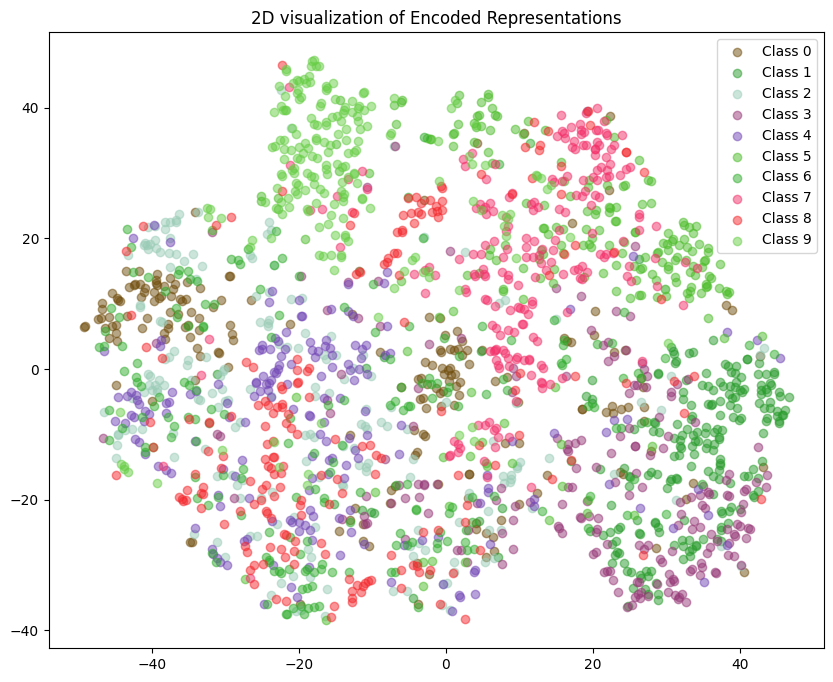

In [ ]:
from sklearn.manifold import TSNE

sample_data = next(iter(DataLoader(fm_train_set, batch_size=2000, shuffle=False)))

def visualize():
  # Plot the encoded representations of the first 2000
  # images from `fm_train_set` on a plane.
  # You must first pass the images to
  # the encoder to get the encoded vectors, and then you
  # must transform these vectors to 2D space using TSNE
  # and plot the points.
  ##############################
  # Your code goes here (15 points)
    
    imgs, labels = sample_data[0], sample_data[1]
    
    imgs, labels = imgs.to(device), labels.to(device)
    
    with torch.no_grad():
        encoded_images = encoder(imgs).cpu().numpy()
        
    tsne = TSNE(n_components=2, random_state=0)
    encoded_2d = tsne.fit_transform(encoded_images)

    # Mapping labels to colors
    labels = labels.cpu().numpy() 
    label_colors = {label: np.random.rand(3,) for label in np.unique(labels)}

    # Plotting
    plt.figure(figsize=(10, 8))
    for label in np.unique(labels):
        plt.scatter(encoded_2d[labels == label, 0], encoded_2d[labels == label, 1], 
                    c=[label_colors[label]], alpha=0.5, label=f'Class {label}')
        
    plt.title('2D visualization of Encoded Representations')
    plt.legend()
    plt.show()

  ##############################

# Testing the function
visualize()

In [ ]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        model.train() 
        for imgs, labels in train_loader:
            # Compute the output.
            # Use GPU for your data if possible.
            ##############################
            # Your code goes here (5 points)

            imgs, labels = imgs.to(device), labels.to(device)
            ##############################

            # Using `loss_fn` and `optimizer`, compute the loss and do the backprop step.
            ##############################
            # Your code goes here (5 points)

            pred = model(imgs)
            loss_train = loss_fn(pred, labels) 
            
            loss_train.backward()
            optimizer.step() 
            optimizer.zero_grad() 
            ##############################
            
        print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))
        # Every 10 epochs, we visualize the encoded representations.
        if epoch % 10 == 0:
          visualize()

Epoch 1, Training loss 8.216765854740515e-05
Epoch 2, Training loss 5.487172893481329e-05
Epoch 3, Training loss 5.656610301230103e-05
Epoch 4, Training loss 4.787534999195486e-05
Epoch 5, Training loss 4.724225073005073e-05
Epoch 6, Training loss 5.109354970045388e-05
Epoch 7, Training loss 4.398184682941064e-05
Epoch 8, Training loss 4.11887485824991e-05
Epoch 9, Training loss 4.171222826698795e-05
Epoch 10, Training loss 3.974829087383114e-05


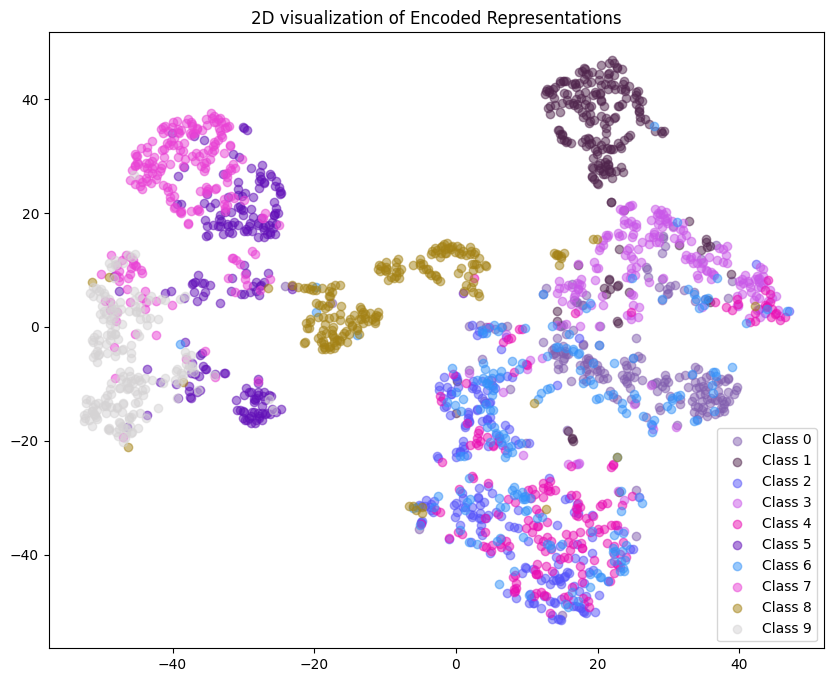

Epoch 11, Training loss 4.025927773909643e-05
Epoch 12, Training loss 3.8321893953252584e-05
Epoch 13, Training loss 4.064335735165514e-05
Epoch 14, Training loss 4.3116833694512025e-05
Epoch 15, Training loss 3.544321589288302e-05
Epoch 16, Training loss 4.001460547442548e-05
Epoch 17, Training loss 3.639766146079637e-05
Epoch 18, Training loss 3.447460039751604e-05
Epoch 19, Training loss 3.2540017855353653e-05
Epoch 20, Training loss 3.7379464629339054e-05


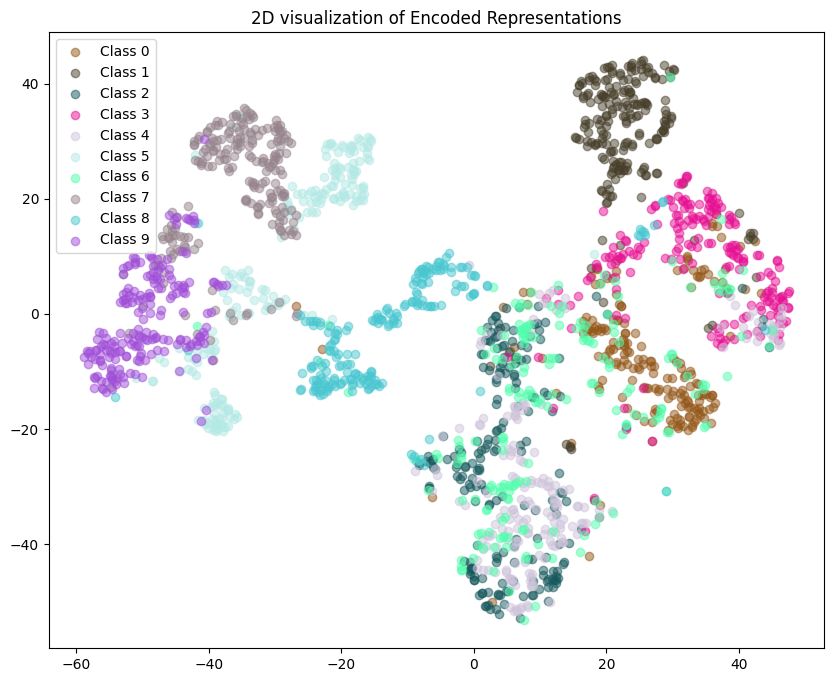

Epoch 21, Training loss 3.384207593626343e-05
Epoch 22, Training loss 3.381498027010821e-05
Epoch 23, Training loss 3.0199340471881442e-05
Epoch 24, Training loss 3.3832184271886945e-05
Epoch 25, Training loss 3.4926895750686526e-05
Epoch 26, Training loss 3.0351506211445667e-05
Epoch 27, Training loss 3.2161806302610785e-05
Epoch 28, Training loss 3.4617485653143376e-05
Epoch 29, Training loss 3.239993748138659e-05
Epoch 30, Training loss 3.4896387660410255e-05


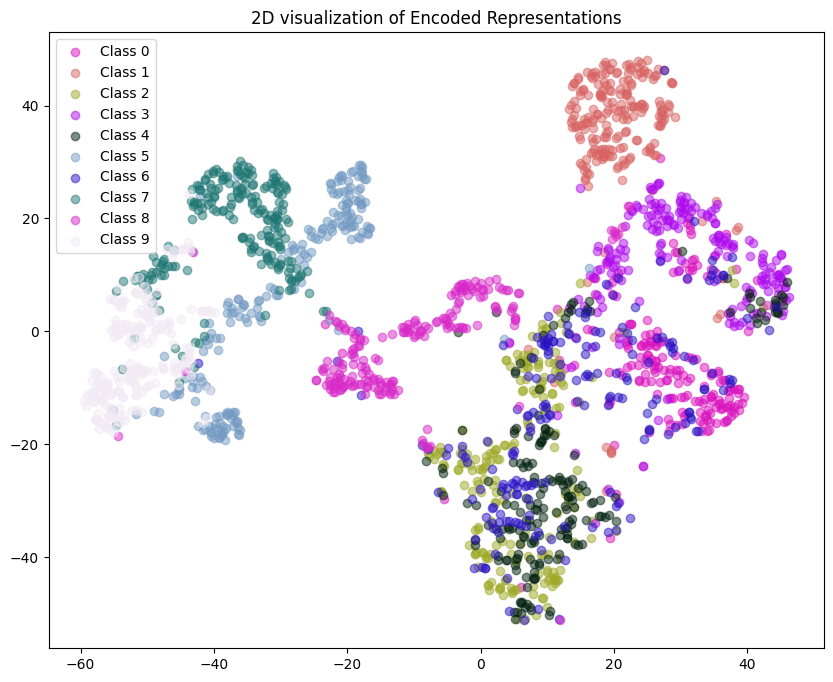

Epoch 31, Training loss 3.63556609954685e-05
Epoch 32, Training loss 3.298533192719333e-05
Epoch 33, Training loss 3.264806218794547e-05
Epoch 34, Training loss 3.191138239344582e-05
Epoch 35, Training loss 3.255100091337226e-05
Epoch 36, Training loss 2.994660462718457e-05
Epoch 37, Training loss 3.199500497430563e-05
Epoch 38, Training loss 2.962362668768037e-05
Epoch 39, Training loss 3.207086774636991e-05
Epoch 40, Training loss 2.7824360586237162e-05


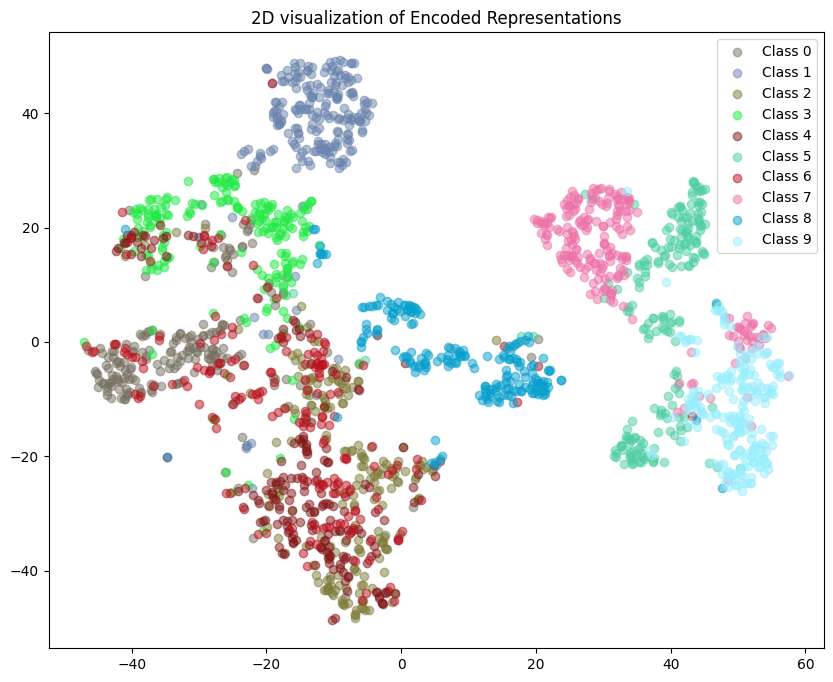

Epoch 41, Training loss 2.966162901429925e-05
Epoch 42, Training loss 3.352202838868834e-05
Epoch 43, Training loss 3.3830019674496725e-05
Epoch 44, Training loss 2.8081758500775322e-05
Epoch 45, Training loss 2.996721195813734e-05
Epoch 46, Training loss 3.36149605573155e-05
Epoch 47, Training loss 2.98270424536895e-05
Epoch 48, Training loss 2.8849941372754984e-05
Epoch 49, Training loss 3.2437405025120825e-05
Epoch 50, Training loss 3.219057907699607e-05


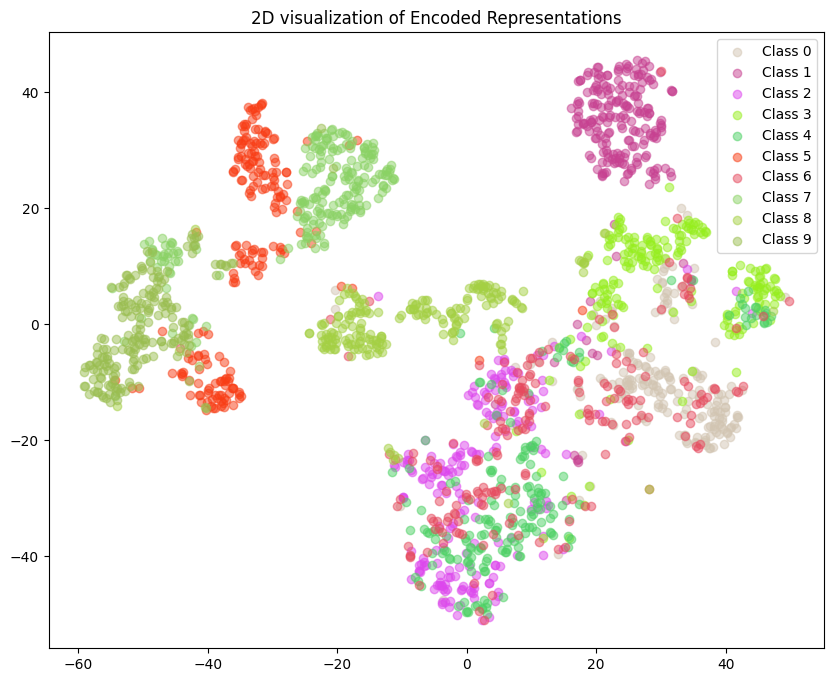

Epoch 51, Training loss 2.5078514227061532e-05
Epoch 52, Training loss 2.7976580895483494e-05
Epoch 53, Training loss 3.141008346574381e-05
Epoch 54, Training loss 3.031473170267418e-05
Epoch 55, Training loss 2.7302965463604778e-05
Epoch 56, Training loss 2.992559711856302e-05
Epoch 57, Training loss 2.6376223104307428e-05
Epoch 58, Training loss 3.122075941064395e-05
Epoch 59, Training loss 2.8519723855424672e-05
Epoch 60, Training loss 2.8708684112643823e-05


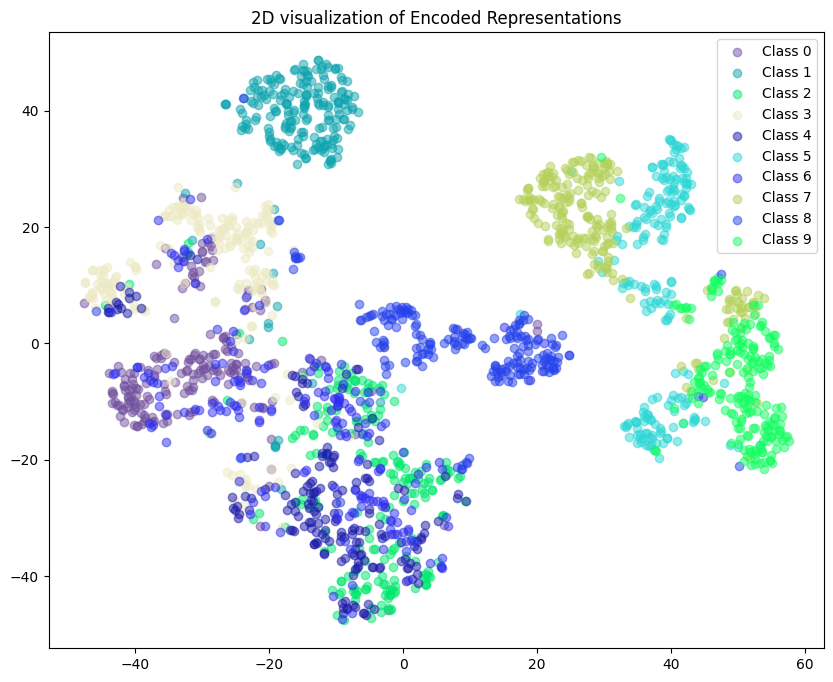

Epoch 61, Training loss 2.7988913643639535e-05
Epoch 62, Training loss 2.8957387257833034e-05
Epoch 63, Training loss 2.863345798687078e-05
Epoch 64, Training loss 2.7766767743742093e-05
Epoch 65, Training loss 2.8922000637976453e-05
Epoch 66, Training loss 2.747679354797583e-05
Epoch 67, Training loss 2.903413405874744e-05
Epoch 68, Training loss 2.790893086057622e-05
Epoch 69, Training loss 2.881677391997073e-05
Epoch 70, Training loss 2.8335640308796428e-05


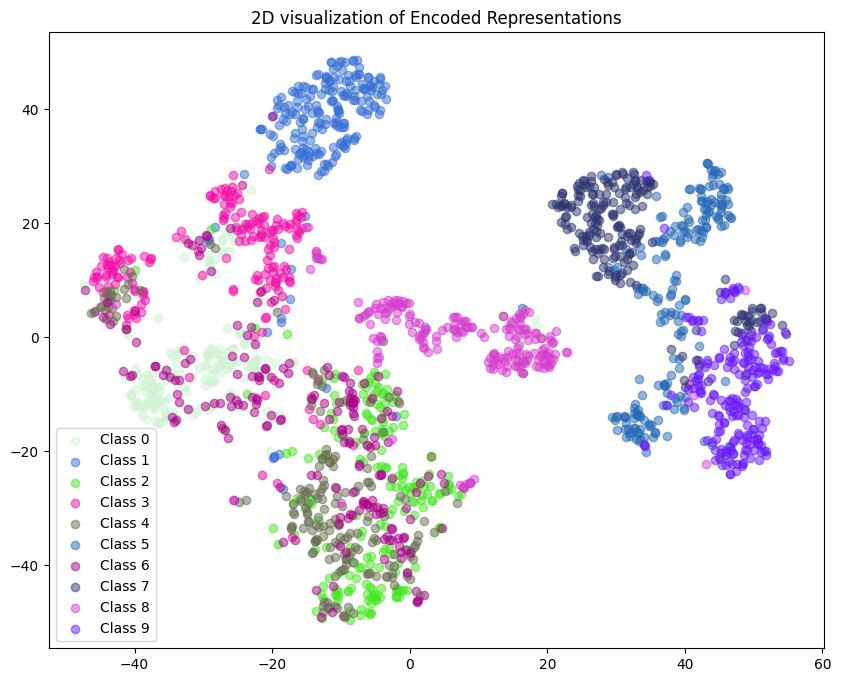

Epoch 71, Training loss 3.1051207770360634e-05
Epoch 72, Training loss 2.7716276235878468e-05
Epoch 73, Training loss 3.116048173978925e-05
Epoch 74, Training loss 2.8945107260369696e-05
Epoch 75, Training loss 2.5905772417900153e-05
Epoch 76, Training loss 2.6199284548056312e-05
Epoch 77, Training loss 3.1837324058869854e-05
Epoch 78, Training loss 2.8884169296361506e-05
Epoch 79, Training loss 3.0607825465267524e-05
Epoch 80, Training loss 3.100655158050358e-05


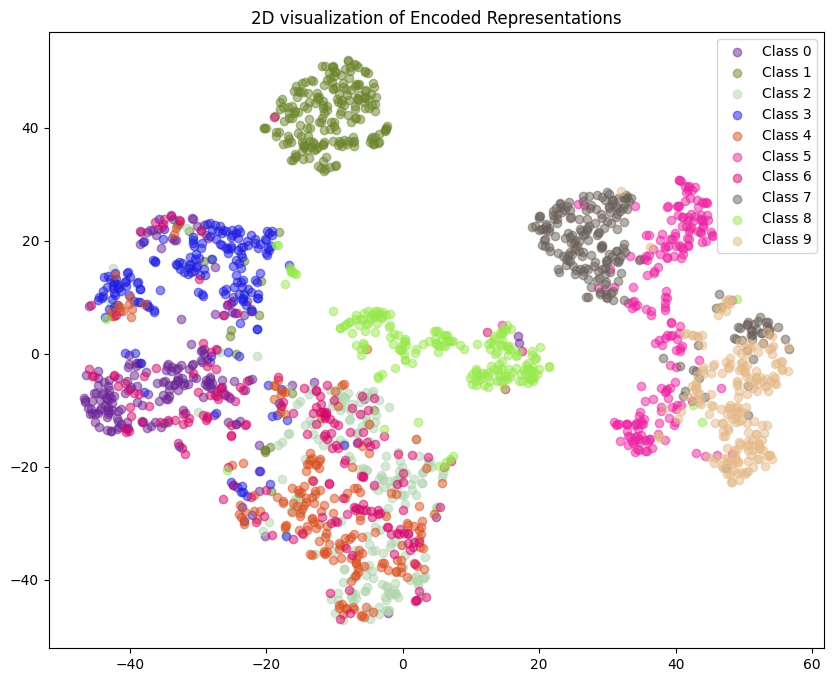

Epoch 81, Training loss 2.792096529447008e-05
Epoch 82, Training loss 2.8072114218957722e-05
Epoch 83, Training loss 2.4658898837515153e-05
Epoch 84, Training loss 2.8895705327158794e-05
Epoch 85, Training loss 3.138375177513808e-05
Epoch 86, Training loss 2.9096992875565775e-05
Epoch 87, Training loss 2.9347094823606312e-05
Epoch 88, Training loss 2.753455009951722e-05
Epoch 89, Training loss 2.4972310711746104e-05
Epoch 90, Training loss 3.0381484975805506e-05


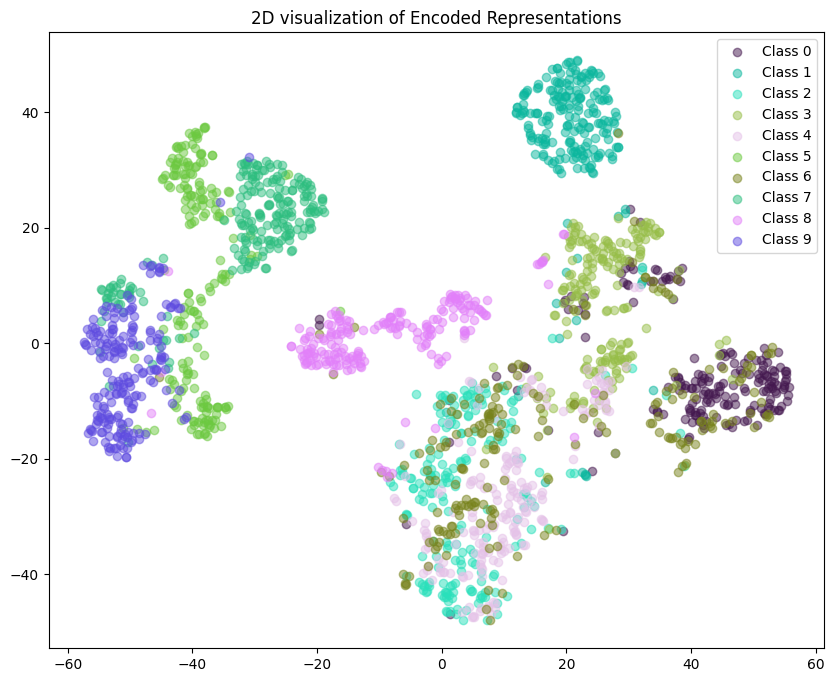

Epoch 91, Training loss 2.764537748589646e-05
Epoch 92, Training loss 2.7927431801799685e-05
Epoch 93, Training loss 2.579637111921329e-05
Epoch 94, Training loss 2.8094344088458456e-05
Epoch 95, Training loss 2.3564492948935367e-05
Epoch 96, Training loss 2.5863935661618598e-05
Epoch 97, Training loss 2.7512613087310456e-05
Epoch 98, Training loss 2.52776917477604e-05
Epoch 99, Training loss 2.6816258468898013e-05
Epoch 100, Training loss 2.8610571462195367e-05


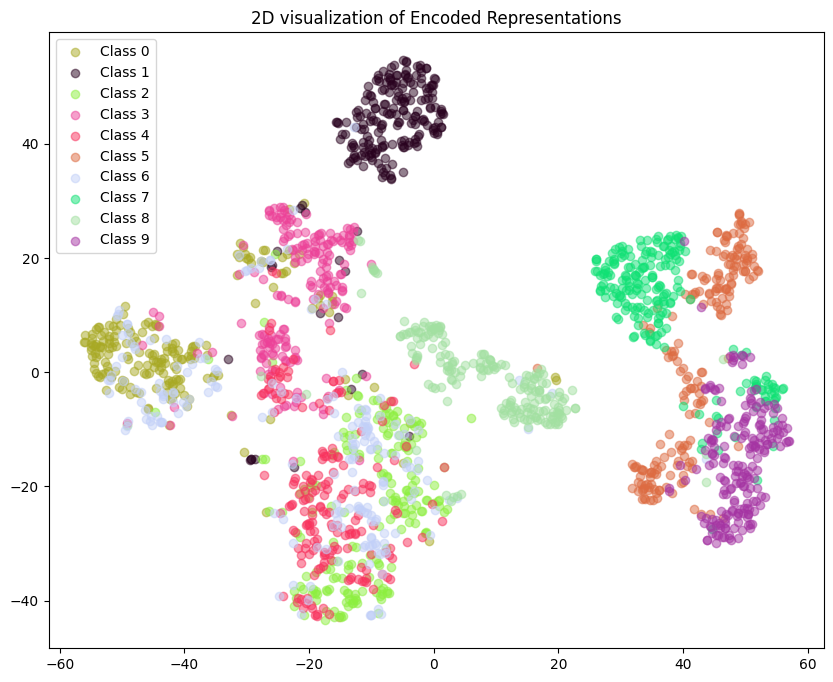

In [15]:
epochs = 100
# Train the DAE. use MSE as the loss function and 
# use Adam for the optimizer. Set the learning rate to 1e-3.
##############################
# Your code goes here (5 points)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(DAE.parameters(), lr=1e-3)
train(epochs, optimizer, DAE, loss_fn, train_loader)

##############################

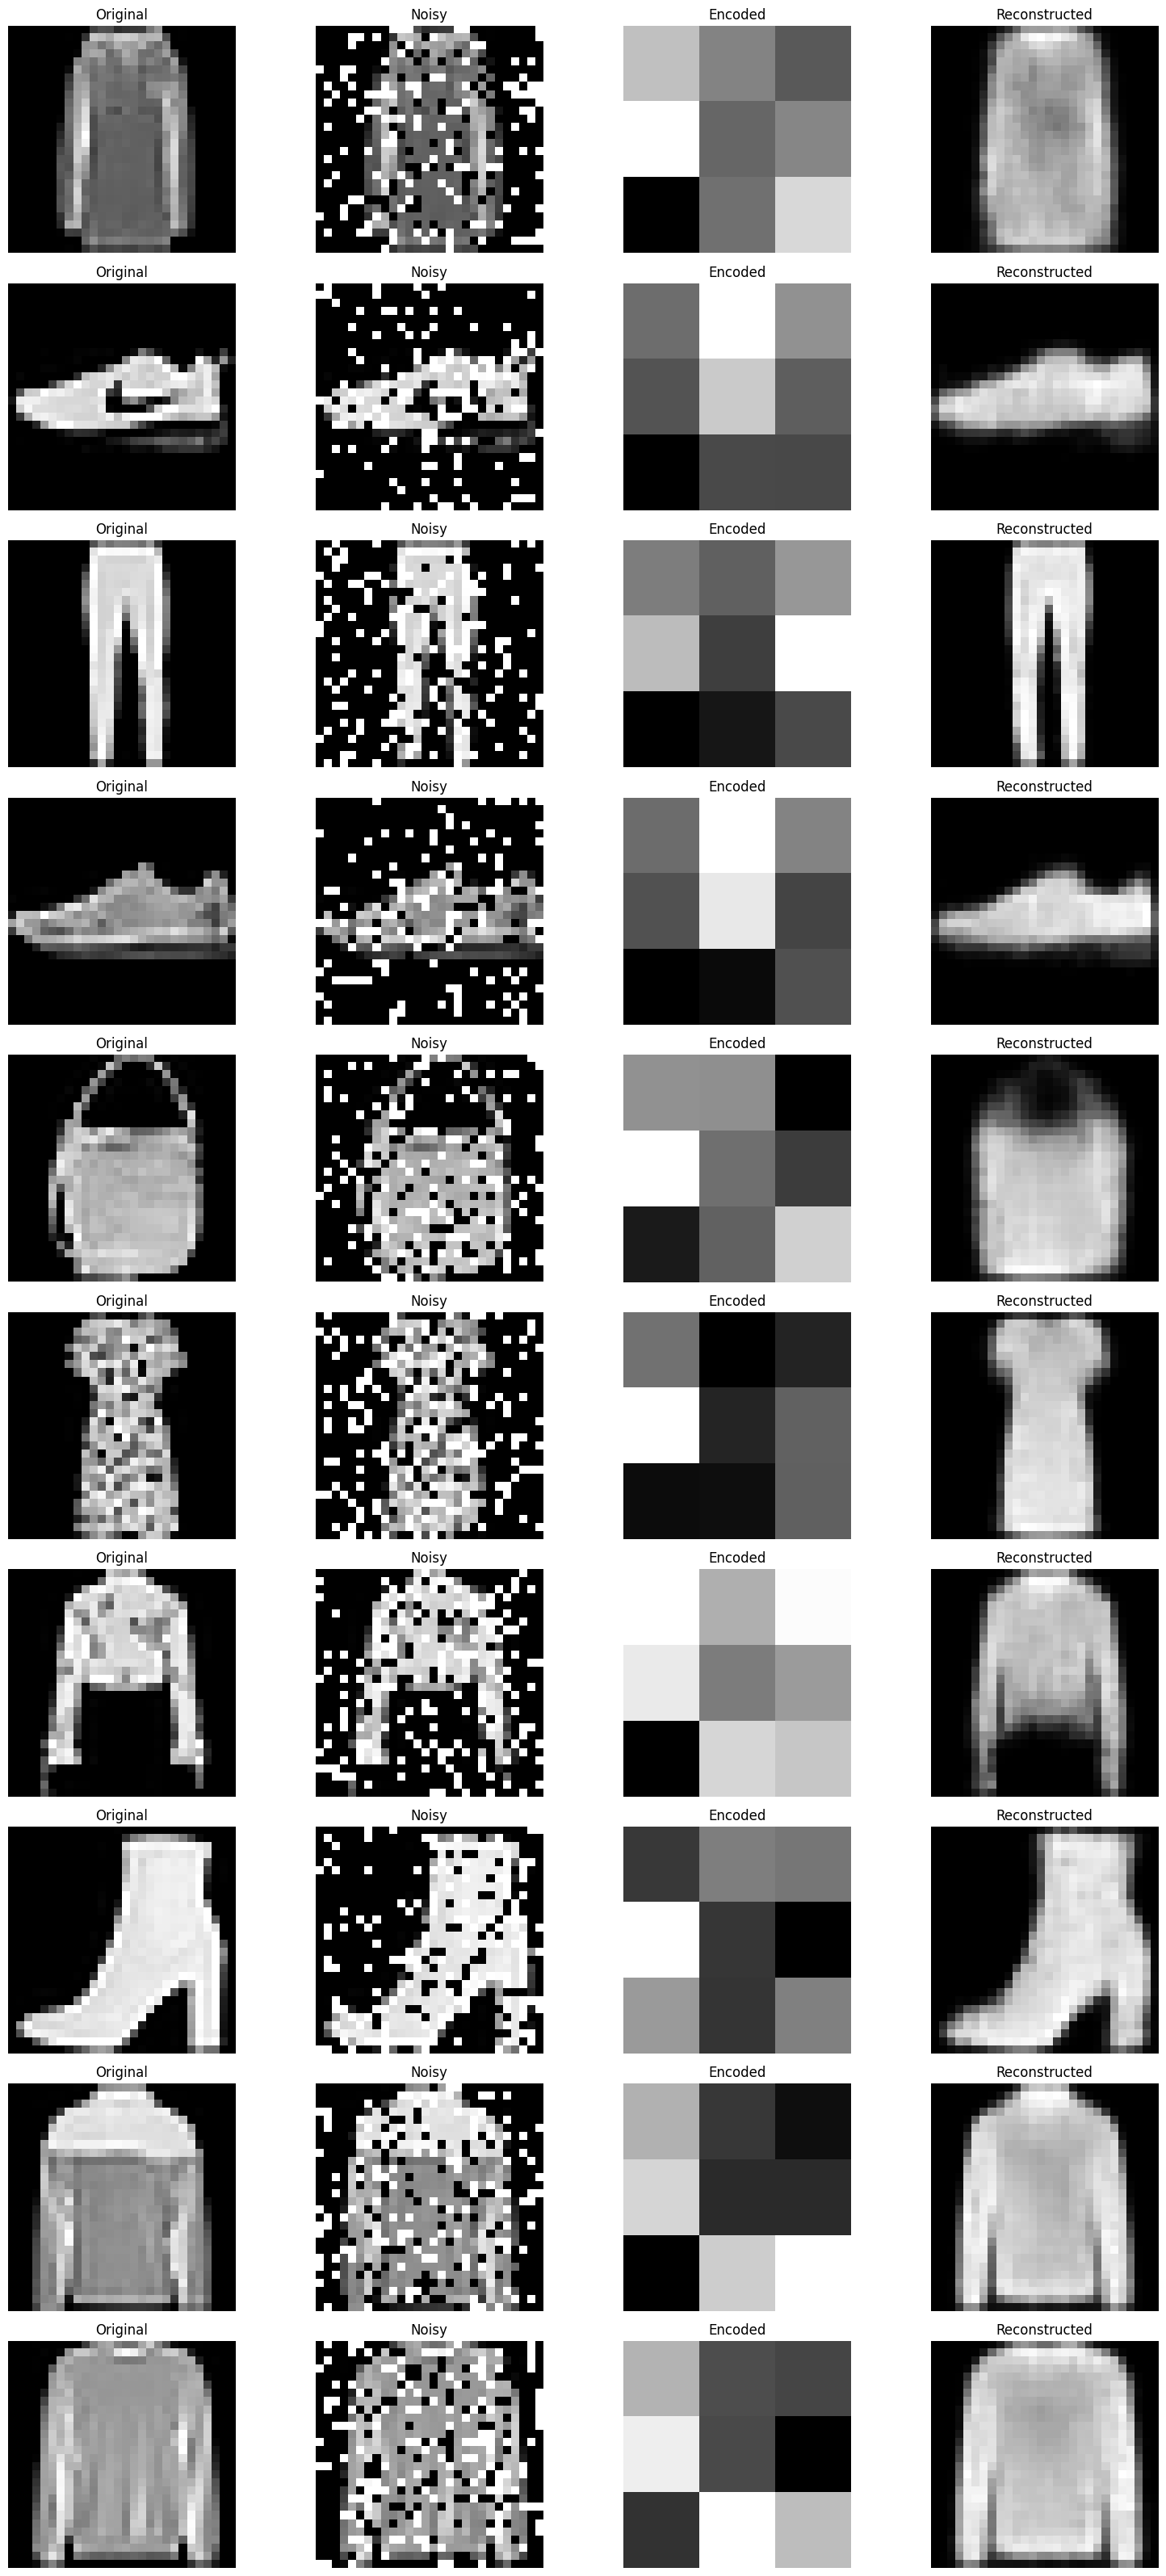

In [55]:
# Use 10 examples from the testing set to evaluate the 
# DAE's outputs visually.
##############################
# Your code goes here (5 points)
def visualize_output(encoder, decoder, test_loader, num_examples=10):
    with torch.no_grad():
        fig, axes = plt.subplots(num_examples, 4, figsize=(16, 32))
        for i, (noisy_images, images) in enumerate(test_loader):
            if i == num_examples:
                break
            images = images.to(device)
            noisy_images = noisy_images.to(device)
            # Assuming you have a function to add noise to images
            
            # Original image
            axes[i, 0].imshow(images[0][0].cpu(), cmap='gray')
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')
            
            # Noisy image
            axes[i, 1].imshow(noisy_images[0][0].cpu(), cmap='gray')
            axes[i, 1].set_title('Noisy')
            axes[i, 1].axis('off')
            
            # Latent image given to encoder
            encoded_images = encoder(noisy_images)
            axes[i, 2].imshow(encoded_images[0][:9].reshape(3,3).cpu(), cmap='gray')
            axes[i, 2].set_title('Encoded')
            axes[i, 2].axis('off')
            
            # Reconstructed image
            reconstructed_images = decoder(encoded_images)
            axes[i, 3].imshow(reconstructed_images[0].squeeze(0).cpu(), cmap='gray')
            axes[i, 3].set_title('Reconstructed')
            axes[i, 3].axis('off')
            
        plt.tight_layout()
        plt.show()

# Visualize output on test data
visualize_output(encoder, decoder, test_loader)

##############################